<center>
<img src="https://upload.wikimedia.org/wikipedia/commons/4/47/Acronimo_y_nombre_uc3m.png"/>

<img src="https://mirrors.creativecommons.org/presskit/buttons/88x31/png/by-nc-sa.png" width=15%/>
</center>    

# Detección de mensajes sexistas con CNN

En este notebook, vamos a trabajar con el dataset de la competición [EXIST 2021](#http://nlp.uned.es/exist2021/) cuyo objetivo es la identificación de mensajes sexitas en las redes sociales. 

Este dataset ha sido anotado para las siguientes tareas:

- 1) Clasificación binaria: cada texto es clasificado como un texto con contenido sexista (sexist) o no sexista (non-sexist).
- 2) Una vez que se han clasificado los mensajes sexistas, la segunda tarea es determimar el tipo de sexismo. En particular, se proponen cinco clases: Una vez que un mensaje ha sido catalogado como sexista, la segunda tarea tiene como objetivo categorizar el mensaje según el tipo de sexismo (según la categorización propuesta por expertos y que tiene en cuenta las diferentes facetas de la mujer que se desvirtúan). En particular, proponemos una tarea de cinco clasificaciones:IDEOLOGICAL AND INEQUALITY, STEREOTYPING AND DOMINANCE, OBJECTIFICATION, SEXUAL VIOLENCE, MISOGYNY AND NON-SEXUAL VIOLENCE. Para ver una descripción más detallada de estas clases, visitar este [link](#http://nlp.uned.es/exist2021/).

En este notebook, nos centraremos únicamente en la primera tarea que consiste en una clasificación binaria de los textos. 

El datase debe solicitarse a los organizadores de la competición: jcalbornoz@lsi.uned.es, frodriguez.sanchez@invi.uned.es or lplaza@lsi.uned.es 

- The dataset should only be used for scientific or research purposes. Any other use is explicitly prohibited.
- The datasets must not be redistributed or shared in part or full to any third party. Redirect interested parties to this website.
- All data released for these tasks are under the CC BY-SA 4.0 License (https://creativecommons.org/licenses/by-sa/4.0/legalcode).
- Data must not be used for providing surveillance, analyses or research that isolates a group of individuals or any single individual for any unlawful or discriminatory purpose.




## Dataset

In [1]:
from google.colab import drive
# mount your google drive
drive.mount('/content/drive')
PATH = "/content/drive/My Drive/Colab Notebooks/data/exist2022/"

import pandas as pd

df_train = pd.read_csv(PATH+"EXIST2021_training.tsv",  sep='\t') 
df_test = pd.read_csv(PATH+"EXIST2021_test.tsv",  sep='\t') 

print('tamaño training:', df_train.shape)
print('tamaño test:', df_test.shape)

df_train.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
tamaño training: (6977, 7)
tamaño test: (4368, 7)


,test_case,id,source,language,text,task1,task2
0,EXIST2021,1,twitter,en,"She calls herself ""anti-feminazi"" how about sh...",sexist,ideological-inequality
1,EXIST2021,2,twitter,en,"Now, back to these women, the brave and the be...",non-sexist,non-sexist
2,EXIST2021,3,twitter,en,"@CurvyBandida @Xalynne_B Wow, your skirt is ve...",sexist,objectification
3,EXIST2021,4,twitter,en,@AurelieGuiboud Incredible! Beautiful!But I l...,non-sexist,non-sexist
4,EXIST2021,5,twitter,en,i find it extremely hard to believe that kelly...,non-sexist,non-sexist


Para la tarea de clasificación binaria, vamos a utilizar únicamente el texto y el campo task1, que es nuestro campo label. 

In [2]:
df_train = df_train.drop(['test_case', 'id', 'source', 'task2'], axis=1)
df_test = df_test.drop(['test_case', 'id', 'source', 'task2'], axis=1)
df_train = df_train.rename(columns={'task1':'label'})
df_test = df_test.rename(columns={'task1':'label'})

df_train.head()

,language,text,label
0,en,"She calls herself ""anti-feminazi"" how about sh...",sexist
1,en,"Now, back to these women, the brave and the be...",non-sexist
2,en,"@CurvyBandida @Xalynne_B Wow, your skirt is ve...",sexist
3,en,@AurelieGuiboud Incredible! Beautiful!But I l...,non-sexist
4,en,i find it extremely hard to believe that kelly...,non-sexist


## Label Encoding



En el caso de clasifición binaria, solo necesitamos transformar las labels de texto a número entero:
- non-sexist -> 0
- sexist -> 1

En nuestra red CNN, la última capa está formada por una única neurona con la función de activación sigmoidea, que devuelve una probabilidad, que se transformará al valor 0 o 1. 

Por ese motivo, no necesitamos transformar los etiquetas a categorical (vectores one-hot que presentan cada clase). 

In [3]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical

y_train = df_train['label'].tolist()
y_test = df_test['label'].tolist()

le = LabelEncoder()

print("antes de transform: ", y_train[:10])
y_train = le.fit_transform(y_train)
LABELS = le.classes_

print("después de transform:", y_train[:10])

y_test = le.fit_transform(y_test)


antes de transform:  ['sexist', 'non-sexist', 'sexist', 'non-sexist', 'non-sexist', 'sexist', 'non-sexist', 'non-sexist', 'non-sexist', 'non-sexist']
después de transform: [1 0 1 0 0 1 0 0 0 0]


### Tokenización

Puedes consultar más información sobre el tokenizador de keras en este [link](#https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer).


In [4]:
from keras.preprocessing.text import Tokenizer

X_train = df_train['text'].tolist()

tokenizer = Tokenizer(oov_token = True)
# entrenamos el tokenizador usando los textos del conjunto de entrenamiento
tokenizer.fit_on_texts(X_train)

# el índice 0, en principio, no ha sido asignado a ningún token y está reservado
# en nuestro caso, lo usamos para representar el token para padding
tokenizer.word_index['<PAD>'] = 0

NUM_WORDS=len(tokenizer.word_index)
print("Tamaño del vocabulario ={}".format(NUM_WORDS))


Tamaño del vocabulario =35472


El vocabulario consiste de una lista de las palabras de la colección del texto. Todos los signos de puntuación son eliminados. 

Vamos a mostrar algunas palabras del vocabulario y su índice.



In [5]:
for (word,index) in tokenizer.word_index.items():
    print(index,word)
    if index==5:
        break

1 True
2 a
3 que
4 de
5 la


El tokenizador nos permite representar los textos como una secuencia de enteros. Es decir cada palabra es reemplazada por su índice en el vocabulario. 

In [6]:
# Cada texto es transformado en una secuencia de enteros. 
# En el vocabulario, cada palabra tiene asociado un entero
encoded_train = tokenizer.texts_to_sequences(X_train)


### ¿Cuál es la distribución de la longitud de los textos en el training?


In [7]:
length_train=df_train['text'].apply(lambda text: len(text.split()))
length_train.describe(percentiles=[0.25, 0.50, 0.75, 0.90, 0.95, 0.99])


count    6977.000000
mean       28.870861
std        15.884901
min         2.000000
25%        15.000000
50%        28.000000
75%        43.000000
90%        50.000000
95%        53.000000
99%        58.000000
max       101.000000
Name: text, dtype: float64

In [8]:
length_train.describe(percentiles=[0.25, 0.50, 0.75, 0.90, 0.95, 0.99])


count    6977.000000
mean       28.870861
std        15.884901
min         2.000000
25%        15.000000
50%        28.000000
75%        43.000000
90%        50.000000
95%        53.000000
99%        58.000000
max       101.000000
Name: text, dtype: float64


Vamos a considerar el tamaño máximo como 50 tokens. 

In [9]:
from keras.utils import pad_sequences 
MAX_LEN=50
encoded_train = pad_sequences(encoded_train, maxlen = MAX_LEN, padding='post')


## CNN

In [10]:
import tensorflow as tf 
# asegurar que los experimentos se pueden reproducir
tf.random.set_seed(42)

tf.__version__

'2.11.0'

In [11]:
from keras.models import Sequential
from keras.layers import Flatten, Dense, Embedding, Conv1D, MaxPooling1D

EMBEDDING_SIZE=50 #probar con 200, 300
model = Sequential()

model.add(Embedding(NUM_WORDS, EMBEDDING_SIZE, input_length=MAX_LEN))

model.add(Conv1D(filters=128, kernel_size=4, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))

model.add(Conv1D(filters=64, kernel_size=4, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))

model.add(Conv1D(filters=32, kernel_size=4, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))

model.add(Flatten())
model.add(Dense(50, activation='relu'))
# Para clasificación binaria
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 50)            1773600   
                                                                 
 conv1d (Conv1D)             (None, 50, 128)           25728     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 25, 128)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 25, 64)            32832     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 12, 64)           0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (None, 12, 32)            8

In [12]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
# Para el entrenamiento después de 3 epochs sin el error en el conjunto de validación no mejora
earlyStopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=0, mode='auto')


### Training

Como no tenemos un conjunto de validación explícito, en el método compile específicamos usando el argumento **        validation_split** qué porcentaje del training vamos a usar como conjunto de validación:

In [13]:
epochs = 10 
batch_size = 16 

# training
history=model.fit(encoded_train, y_train, 
                    validation_split=0.2,
                  batch_size=batch_size, epochs=epochs,
                  callbacks=[earlyStopping],
                  )


Epoch 1/10
349/349 [==============================] - 37s 77ms/step - loss: 0.6563 - accuracy: 0.6087 - val_loss: 0.9043 - val_accuracy: 0.4771
Epoch 2/10
349/349 [==============================] - 7s 19ms/step - loss: 0.3699 - accuracy: 0.8398 - val_loss: 1.4947 - val_accuracy: 0.4850
Epoch 3/10
349/349 [==============================] - 6s 17ms/step - loss: 0.0968 - accuracy: 0.9654 - val_loss: 1.7306 - val_accuracy: 0.5208
Epoch 4/10
349/349 [==============================] - 4s 11ms/step - loss: 0.0214 - accuracy: 0.9946 - val_loss: 2.7739 - val_accuracy: 0.5215


### Curvas de aprendizaje

En las curva de aprenzije, el modelo es evaluado en el conjunto de entrenamiento para saber cómo de bien el modelo es capaz de aprender.
Además, el modelo también se evalúa en el conjunto de validación para saber cómo de bien el modelo es capaz de generalizar. 

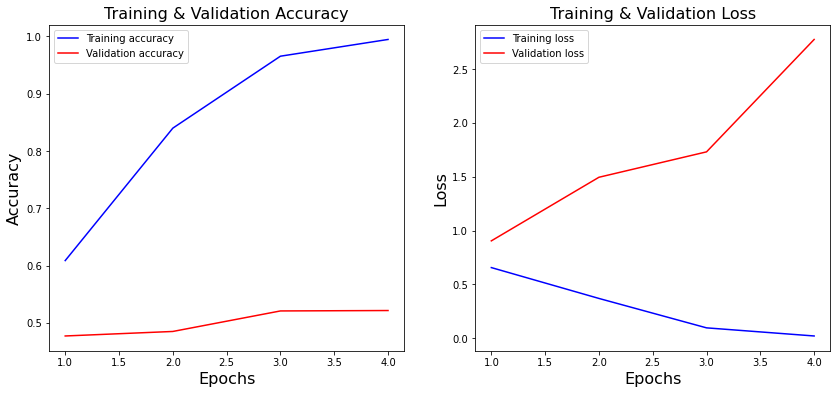

In [14]:
import matplotlib.pyplot as plt

history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
accuracy = history_dict['accuracy']
val_accuracy = history_dict['val_accuracy']
 
epochs = range(1, len(loss_values) + 1)
fig, ax = plt.subplots(1, 2, figsize=(14, 6))
#
# Curva de a  the model accuracy vs Epochs
#
ax[0].plot(epochs, accuracy, 'b', label='Training accuracy')
ax[0].plot(epochs, val_accuracy, 'red', label='Validation accuracy')
ax[0].set_title('Training & Validation Accuracy', fontsize=16)
ax[0].set_xlabel('Epochs', fontsize=16)
ax[0].set_ylabel('Accuracy', fontsize=16)
ax[0].legend()
#
# Plot the loss vs Epochs
#
ax[1].plot(epochs, loss_values, 'b', label='Training loss')
ax[1].plot(epochs, val_loss_values, 'red', label='Validation loss')
ax[1].set_title('Training & Validation Loss', fontsize=16)
ax[1].set_xlabel('Epochs', fontsize=16)
ax[1].set_ylabel('Loss', fontsize=16)
ax[1].legend()

### Evaluación


Aplicamos el modelo sobre el conjunto test, para poder obtener las métricas loss y  accuracy sobre el conjunto final.

In [17]:
X_test = df_test['text'].tolist()
encoded_test = tokenizer.texts_to_sequences(X_test)
encoded_test = pad_sequences(encoded_test, maxlen = MAX_LEN, padding='post')

loss, accuracy = model.evaluate(encoded_test, y_test, batch_size=batch_size)


273/273 [==============================] - 1s 5ms/step - loss: 1.8398 - accuracy: 0.6362


También podemos hacer la evaluación usando las función **classification_report** que nos dará más información sobre los resultados para cada clase:

In [18]:
import numpy as np
from sklearn.metrics import accuracy_score, classification_report 
y_pred = np.round(model.predict(encoded_test))

print('accuracy:', accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=LABELS))

137/137 [==============================] - 0s 2ms/step
accuracy: 0.6362179487179487
              precision    recall  f1-score   support

  non-sexist       0.59      0.76      0.67      2087
      sexist       0.70      0.52      0.60      2281

    accuracy                           0.64      4368
   macro avg       0.65      0.64      0.63      4368
weighted avg       0.65      0.64      0.63      4368



In [19]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, y_pred)
print(cm)

[[1588  499]
 [1090 1191]]


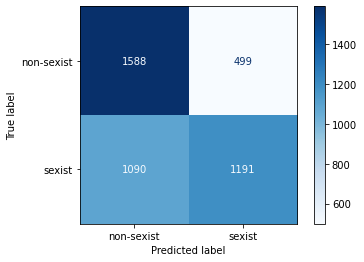

In [20]:

disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=LABELS)
disp.plot(cmap=plt.cm.Blues,values_format='g')


## Discusión


- ¿Qué nos dice la matriz de confusion?
- ¿Supera CNN a SVM?
